# 草稿部分不跑，其他都需要跑

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt



In [2]:
import pymc

print(pymc.__version__)


5.4.1


# 数据清洗

In [3]:
import pandas as pd
import numpy as np

df_flanker = pd.read_csv('flanker_1.csv')
df_flanker['subj_num'] = df_flanker['subj_num'] - 1
# print(df_flanker)

# deleta NA value
df_flanker_na = df_flanker.dropna()

# Select rows where column RT is greater than 0
df_flanker_rt = df_flanker_na[df_flanker_na['RT'] > 0]

n_subj = len(df_flanker_rt['subj_num'].unique())
n_cond = 2
n_time =2

df_flanker_filcon = df_flanker_rt[df_flanker_rt['Condition'] != 1]
df_flanker_filcon_groupby = df_flanker_filcon.groupby(['subj_num', 'Condition', 'Time'])
T_subj_all = df_flanker_filcon_groupby.size().reset_index(name='n_trials')

T_subj_all.reset_index(inplace=True)

T_subj_all = T_subj_all.drop("index", axis=1)

T_max = max(T_subj_all['n_trials'])

# Create RT data array; dims = (subject, condition, time, trial)

T_subj_all.head()
print(T_subj_all.columns)

Index(['subj_num', 'Condition', 'Time', 'n_trials'], dtype='object')


In [4]:
RT = np.zeros((n_subj, n_cond, n_time, T_max))
T_subj = RT_min = np.empty((n_subj, n_cond, n_time))
T_subj[:] = np.nan
correct = np.zeros((n_subj, n_cond, n_time, T_max))

In [5]:
df_flanker.loc[(df_flanker['subj_num'] == 1) & (df_flanker['Condition'] == 0) & (df_flanker['Time'] == 1), 'RT']

df_flanker[(df_flanker['subj_num'] == 1) & (df_flanker['Condition'] == 0) & (df_flanker['Time'] == 1)]['RT']

1442    0.66333
1444    0.55928
1445    0.44864
1446    0.48520
1447    0.61825
         ...   
2144    0.39901
2145    0.41012
2146    0.39072
2147    0.43345
2154    0.45383
Name: RT, Length: 240, dtype: float64

In [6]:
# np.sum((T_subj_all['subj_num'] == 1) & (T_subj_all['Condition'] ==0) & (T_subj_all['Time'] ==1))

int(T_subj_all[(T_subj_all['subj_num'] == 0) & (T_subj_all['Condition'] ==0) & (T_subj_all['Time'] ==1)]['n_trials'].values)


240

In [7]:
for i in range(n_subj): #nsubj+1
    #trials in congruent session1
    c0_t1 = int(T_subj_all[(T_subj_all['subj_num'] == i) & (T_subj_all['Condition'] ==0) & (T_subj_all['Time'] ==1)]['n_trials'].values)
    #trials in incongruent session1
    c2_t1 = int(T_subj_all[(T_subj_all['subj_num'] == i) & (T_subj_all['Condition'] ==2) & (T_subj_all['Time'] ==1)]['n_trials'].values)
    #trials in congruent session2
    c0_t2 = int(T_subj_all[(T_subj_all['subj_num'] == i) & (T_subj_all['Condition'] ==0) & (T_subj_all['Time'] ==2)]['n_trials'].values)
    #trials in incongruent session2
    c2_t2 = int(T_subj_all[(T_subj_all['subj_num'] == i) & (T_subj_all['Condition'] ==2) & (T_subj_all['Time'] ==2)]['n_trials'].values)

    #choice and RTs for congruent condition at time1
    RT[i, 0, 0, :c0_t1] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 0) & (df_flanker_rt['Time'] == 1), 'RT']
    RT_min[i, 0, 0] = np.min(RT[i, 0, 0, :c0_t1])
    correct[i, 0, 0, :c0_t1] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 0) & (df_flanker_rt['Time'] == 1), 'Correct']

    #choice and RTs for incongruent condition at time1
    RT[i, 1, 0, :c2_t1] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 2) & (df_flanker_rt['Time'] == 1), 'RT']
    RT_min[i, 1, 0] = np.min(RT[i, 1, 0, :c2_t1])
    correct[i, 1, 0, :c2_t1] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 2) & (df_flanker_rt['Time'] == 1), 'Correct']

    #choice and RTs for congruent condition at time2
    RT[i, 0, 1, :c0_t2] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 0) & (df_flanker_rt['Time'] == 2), 'RT']
    RT_min[i, 0, 1] = np.min(RT[i, 0, 1, :c0_t2])
    correct[i, 0, 1, :c0_t2] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 0) & (df_flanker_rt['Time'] == 2), 'Correct']

    #choice and RTs for incongruent condition at time2
    RT[i, 1, 1, :c2_t2] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 2) & (df_flanker_rt['Time'] == 2), 'RT']
    RT_min[i, 1, 1] = np.min(RT[i, 1, 1, :c2_t2])
    correct[i, 1, 1, :c2_t2] = df_flanker_rt.loc[(df_flanker_rt['subj_num'] == i) & (df_flanker_rt['Condition'] == 2) & (df_flanker_rt['Time'] == 2), 'Correct']


# 测试（草稿，不重要,不要跑）

In [7]:
# import numpy as np
# a = 4
# matrix = np.empty((a,2))

# print(matrix)

# b = np.empty((n_subj,n_time))
# print(b)
# RT[i,j,k,1:T_subj[i,j,k]]
T_subj[0,0,0]


0.22698

In [8]:
import numpy as np
a = np.array([1.0,2.0])
a_reshape = a.reshape(2,1)
b = np.diag(a)
print(b)

[[1. 0.]
 [0. 2.]]


In [9]:
import pymc as pm
import numpy as np

with pm.Model():
    mu = pm.HalfNormal('mu', sigma=1, shape=2)

    mu_diag = np.array([[mu[0].eval(), 0], [0, mu[1].eval()]])

mu_diag[0,1]

0.0

In [12]:

np.diag(np.array([mu_sd_delta[0].eval(),mu_sd_delta[1].eval()]))

array([[1.90219936, 0.        ],
       [0.        , 0.15332335]])

In [ ]:
a = mu_i_delta_pr[0,42].eval()
a

array(-0.2671504)

In [ ]:
b= np.dot(mu_sd_delta_re,L_R_mu)
b

array([[1.09339633, 0.        ],
       [0.03660495, 0.38706313]])

In [13]:
np.dot(mu_sd_delta_re,L_R_mu) * mu_i_delta_pr[0,1].eval()

array([[-2.24027503, -0.        ],
       [-0.18186723, -0.28610473]])

In [ ]:
scaled_L_R_mu = L_R_mu * mu_sd_delta_re
tilde_help = scaled_L_R_mu * mu_i_delta_pr

In [17]:
matrix_2 = np.array([[1, 2], [3, 4]])
matrix_47 = np.ones((2, 47))

a = np.dot(matrix_2,matrix_47)
a.shape

(2, 47)

In [32]:
L_S_mu = np.dot(mu_sd_delta_re,L_R_mu)
mu_i_delta_tilde = np.dot(L_S_mu, mu_i_delta_pr.eval())

In [24]:
mu_sd_delta_re

array([[1.90219936, 0.        ],
       [0.        , 0.15332335]])

In [20]:
mu_i_delta_pr.eval()

array([[ 0.06513032, -1.28595497, -0.24450909,  0.5660117 ,  1.19188953,
        -0.88505286, -1.59160159,  0.0314278 ,  0.46288203,  1.06191241,
        -0.35759963,  0.31212872,  0.09291158,  1.21073317,  0.64993793,
         0.38189718,  1.05682714, -2.43277933, -1.08916414, -0.91986957,
        -0.16693726, -0.69735779,  1.26832503, -0.83686214, -0.89382891,
        -0.73199514, -0.35459638, -0.41468919,  0.25263511,  2.99413486,
         1.23458854, -0.33672782,  0.81348161, -0.29068822, -0.78854122,
         0.16921749,  1.20470033,  0.20686301,  0.35264931,  0.13590621,
        -0.7940533 , -0.84771144,  0.16197534,  0.82355862, -0.22965137,
        -1.18630191, -0.0073439 ],
       [ 0.70601475,  0.86522276, -0.52708388,  0.62973166, -0.41403   ,
         0.92070714, -2.22049652, -0.3988137 , -0.81108604, -0.03623099,
        -1.239854  , -0.30124701, -0.36471173, -0.4323321 ,  1.77119639,
         1.18693268,  0.96497071, -0.50683533,  0.06478546,  0.22149643,
        -0.33263

In [24]:
mu_i_base_pr[0,0].eval()

array(-0.79648075)

In [25]:
mu_mean_base[0].eval() + mu_sd_base[0].eval() *mu_i_base_pr[0,0].eval()

-1.8255657350400787

In [30]:
mu_mean_base[0] + mu_sd_base[0] *mu_i_base_pr[0,0]


Elemwise{add,no_inplace}.0

# 介绍

每个被试的反应时分布服从一个正态分布：

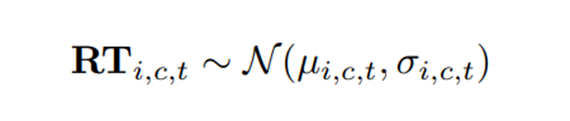

每个被试在time1进行一次测试，time2进行一次测试（即t），每次测试包含一致和不一致两个条件（即c）（所以每个被试会有4个分布）
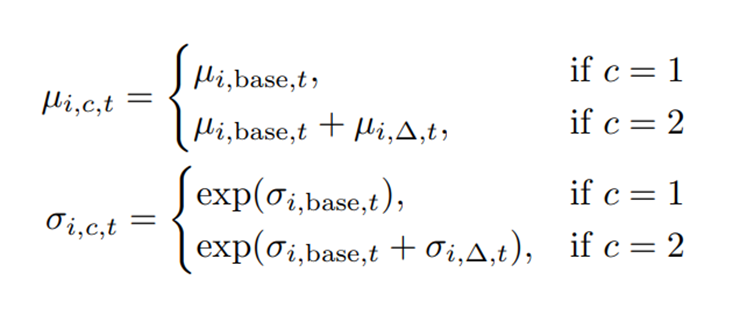

对每个被试来说，反应时分布里的均值和标准差，都是组水平和个体水平的组合
以一致条件的平均值（即c=1）为例（$\mu_{i,base,t}$）<br>
**所以最关键的应该也是把这个公式写出来**
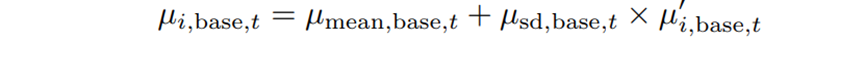 （公式1）

$\mu_{mean,base,t}$, $\mu_{sd,base,t}$是组水平的，$\mu_{i,base,t}$是个体水平的
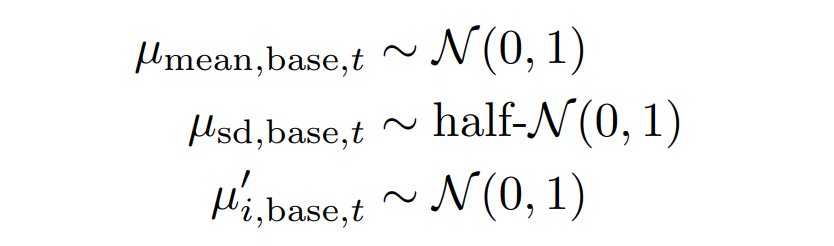



不一致条件则需要再定义$\mu_{i,\delta,t}$,（定义为一致性效应）同样是组水平和个体水平的结合

但一致性效应的平均值和标准差是服从MVNormal分布（因为涉及到重测信度，希望两次测得的一致性效应是高度相关的）
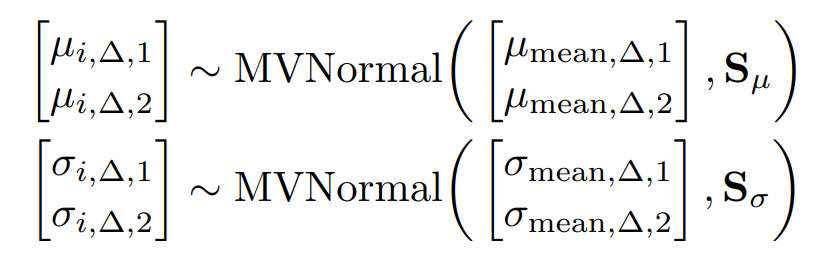

组水平和个体水平的组合写成：

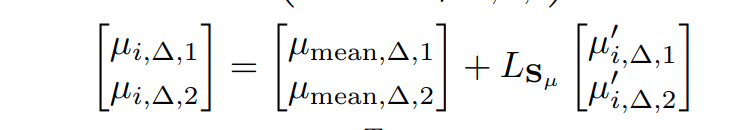 (公式2)

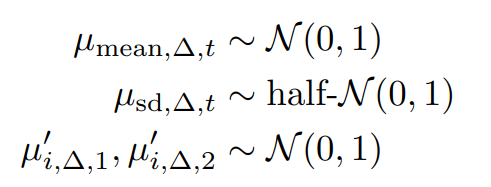

这里的$S_{\mu}$为协方差矩阵，文章中进行了cholesky 分解，简单来说这个步骤可以变成：

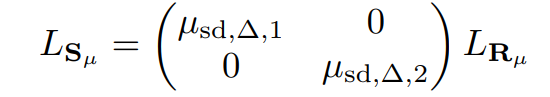

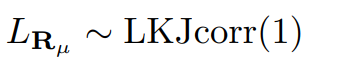




# 模型定义

In [10]:
with pm.Model() as model:
    # Group-level correlation matrix, ref:https://www.pymc.io/projects/examples/en/latest/case_studies/LKJ.html
    packed_L_R_mu = pm.LKJCholeskyCov("packed_L_R_mu", eta=1, n=2,  sd_dist=pm.HalfNormal.dist(1),compute_corr=False)
    packed_L_R_sigma = pm.LKJCholeskyCov("packed_L_R_sigma", eta=1, n=2,  sd_dist=pm.HalfNormal.dist(1),compute_corr=False)

    # 因为我需要使用L_R_mu进行运算，见上图公式，需要跟对角矩阵相乘。我问gpt，它说.eval()可以获得其中的值
    #.eval()这个用法会重复出现，因为需要使用先验进行计算。
    L_R_mu = pm.expand_packed_triangular(2, packed_L_R_mu).eval()
    L_R_sigma = pm.expand_packed_triangular(2, packed_L_R_sigma).eval()
    
    # Group-level parameter means
    # shape=2, because there are two sessions
    mu_mean_base = pm.Normal('mu_mean_base',mu=0, sigma=1, shape=2)
    mu_mean_delta = pm.Normal('mu_mean_delta', mu=0, sigma=1, shape=2)
    sigma_mean_base = pm.Normal('sigma_mean_base', mu=0, sigma=1, shape=2)
    sigma_mean_delta = pm.Normal('sigma_mean_delta', mu=0, sigma=1, shape=2)

    # Group-level parameter sds
    mu_sd_base = pm.HalfNormal('mu_sd_base', sigma=1, shape=2)
    mu_sd_delta = pm.HalfNormal('mu_sd_delta', sigma=1, shape=2)
    sigma_sd_base = pm.HalfNormal('sigma_sd_base', sigma=1, shape=2)
    sigma_sd_delta = pm.HalfNormal('sigma_sd_delta', sigma=1, shape=2)

    # to make diagnol matrix/ can multiply with L_R_mu/L_R_sigma
    mu_sd_delta_re = np.diag(np.array([mu_sd_delta[0].eval(),mu_sd_delta[1].eval()]))
    sigma_sd_delta_re = np.diag(np.array([sigma_sd_delta[0].eval(),sigma_sd_delta[1].eval()]))

    N = n_subj

    # individual-level parameters 
    mu_i_base_pr = pm.Normal('mu_i_base_pr', mu=0, sigma=1, shape=(N,2))
    mu_i_delta_pr = pm.Normal("mu_i_delta_pr", mu=0, sigma=1, shape=(2, N))
    sigma_i_base_pr = pm.Normal("sigma_i_base_pr", mu=0, sigma=1, shape=(N, 2))
    sigma_i_delta_pr = pm.Normal("sigma_i_delta_pr", mu=0, sigma=1, shape=(2, N))

    # the following code is a part of my previous code, cuz the computation can not take place inside pm.Determinictic, so i don't use any pm.Determinictic later

    ## Individual-level parameter off-sets (for non-centered parameterization) #?why tilde
    # mu_i_delta_tilde = pm.Deterministic('mu_i_delta_tilde',np.dot((np.dot(mu_sd_delta_re,L_R_mu), mu_i_delta_pr)))
    # sigma_i_delta_tilde = pm.Deterministic('sigma_i_delta_tilde', np.dot((np.dot(sigma_sd_delta_re, L_R_sigma), sigma_i_delta_pr)))

    mu_i_base = np.empty((n_subj,n_time))
    sigma_i_base = np.empty((n_subj,n_time))
    mu_i_delta = np.empty((n_subj,n_time))
    sigma_i_delta = np.empty((n_subj,n_time))
    mu_i_delta_tilde = np.empty((n_time,n_subj))
    sigma_i_delta_tilde = np.empty((n_time,n_subj))

    # 得到公式2的后半部分
    L_S_mu = np.dot(mu_sd_delta_re,L_R_mu)
    L_S_sigma = np.dot(sigma_sd_delta_re, L_R_sigma)
    mu_i_delta_tilde = np.dot(L_S_mu, mu_i_delta_pr.eval())
    sigma_i_delta_tilde = np.dot(L_S_sigma, sigma_i_delta_pr.eval())


    # 得到公式1
    for i in range(n_subj):
        # mu congruent at session1
        mu_i_base[i,0] = (mu_mean_base[0] + mu_sd_base[0]*mu_i_base_pr[i,0]).eval()
        # mu congruent at session2
        mu_i_base[i,1] = (mu_mean_base[1] + mu_sd_base[1]*mu_i_base_pr[i,1]).eval()
        # sigma congruent at session1
        sigma_i_base[i,0] = (sigma_mean_base[0] + sigma_sd_base[0]*sigma_i_base_pr[i,0]).eval()
        # sigma congruent at session2
        sigma_i_base[i,1] = (sigma_mean_base[1] + sigma_sd_base[1]*sigma_i_base_pr[i,1]).eval()

        # mu incongruent at session1
        mu_i_delta[i,0] = (mu_mean_delta[0] + mu_i_delta_tilde[0,i]).eval()
        # mu incongruent at session2
        mu_i_delta[i,1] = (mu_mean_delta[1] + mu_i_delta_tilde[1,i]).eval()
        #sigma incongruent at session1
        sigma_i_delta[i,0] = (sigma_mean_delta[0] + sigma_i_delta_tilde[0,i]).eval()
        #sigma incongruent at session1
        sigma_i_delta[i,1] = (sigma_mean_delta[1] + sigma_i_delta_tilde[1,i]).eval()

    #得到likelihood 
    for i in range(n_subj):
        for k in range(n_time): #[0,1]
            for j in range(n_cond): #[0,1]
                if j == 0: #[0,0][1,0]
                    RT_lik = pm.Normal('RT_lik_{}_{}_{}'.format(i,j,k), mu = mu_i_base[i,k], 
                                        sigma = pm.math.exp(sigma_i_base[i,k]), 
                                        observed = RT[i,j,k,:])
                else: #[0,1][1,1]
                    RT_lik = pm.Normal('RT_lik_{}_{}_{}'.format(i,j,k), mu = mu_i_base[i,k] + mu_i_delta[i,k], 
                                        sigma = pm.math.exp(sigma_i_base[i,k] + sigma_i_base[i,k]), 
                                        observed = RT[i,j,k,:]) 
 

# 测试 （草稿，不重要，不要跑）

In [ ]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov(
        "packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False
    )
    L = pm.expand_packed_triangular(2, packed_L)

L.eval()

array([[ 1.02860221,  0.        ],
       [-0.4347604 ,  0.50484306]])

In [ ]:
mu_sd_delta[0]

Subtensor{int64}.0

In [ ]:
print("mu_sd_delta_re shape:", mu_sd_delta_re.shape)
print("L_R_mu shape:", L_R_mu.shape)
print("mu_i_delta_pr shape:", mu_i_delta_pr.shape)

mu_sd_delta_re shape: (1,)
L_R_mu shape: Shape.0
mu_i_delta_pr shape: TensorConstant{[ 2 47]}
